# 2021/11/5
# 本代码绘制区域平均的、越赤道气流强度、孟加拉湾东部降水的时间序列
# 旨在判断他们的协同变化

In [6]:
import os
import sys
import xarray as xr
import numpy as np
module_path = ["/home/sun/mycode/module/","/data5/2019swh/mycode/module/"]
sys.path.append(module_path[0])
from module_sun import *


In [7]:
path    =  "/home/sun/data/merra2_multi/"
files   =  os.listdir(path)  ;  files.sort()

level   =  925

f0      =  xr.open_dataset(path+"0707.climate.nc")

# 生成一个数组储存单层气流
u       =  np.zeros((365,f0.U.shape[2],f0.U.shape[3]))
v       =  u.copy()

# 把数据放进去
for i in range(0,len(files)):
    f1      =  xr.open_dataset(path+files[i]).sel(lev=level)
    u[i,:]  =  f1.U.data[0,:]
    v[i,:]  =  f1.V.data[0,:]


# 处理降水数据
f2       =  xr.open_dataset("/home/sun/data/gpcp_prect_365_climate.nc")

# 给u v加上维度属性
wind     =xr.Dataset(
    {
        "u": (["time", "lat", "lon"], u),
        "v": (["time", "lat", "lon"], v),
    },
    coords={
        "lon": (["lon"], f0.lon.data),
        "lat": (["lat"], f0.lat.data),
        "time": (["time"], np.linspace(1,365,365)),
    },
)




In [8]:
# 设计个给出经纬度计算区域平均的函数
def cal_regional_average(var,axis_turple):
    average_data  =  np.zeros((var.shape[0]))

    for i in range(0,var.shape[0]):
        average_data[i]  =  np.nanmean(var.sel(lat=slice(axis_turple[0],axis_turple[1]),lon=slice(axis_turple[2],axis_turple[3])).data[i,:])
    
    return average_data

# 现在开始对印度洋的越赤道气流进行统计分析
# 40-50 50-60 60-70 70-80 80-90 90-100
# 纬度先试试-5 5

In [9]:
cross_equator   =   np.zeros((6,365))
for i in range(40,100,10):
    cross_equator[int((i-40)/10),:]  =  cal_regional_average(wind.v,(-10,10,i,i+10))

# 计算区域平均降水
f2.prect.data[f2.prect.data>100]  =  0
bob_prect  =  cal_regional_average(f2.prect,(5,15,90,100))

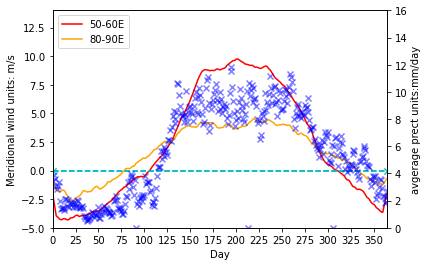

In [10]:
#平滑
labels =  ['40-50E', '50-60E', '60-70E', '70-80E', '80-90E', '90-100E']
filted =  np.zeros((6,365))
fig    =  plt.figure()
ax     =  fig.add_subplot(111)
for i in range(1,5):
    filted[i,:]  =  np.convolve(cross_equator[i,:],np.ones(9)/9,mode='same')
    
    
ax.plot(filted[1],label=labels[1],color='red')
ax.plot(filted[4],label=labels[4],color='orange')

ax.set_xlim((0, 365))
ax.set_ylim((-5, 14))
ax.set_xticks(np.arange(0,365,25))

ax.plot([0,365],[0,0],'cx--')
ax.plot([0,365],[0,0],'cx--')

ax.legend(loc='upper left')

ax.set_ylabel("Meridional wind units: m/s")
ax.set_xlabel("Day")

ax2  =  ax.twinx()
filted_bob_prect  =  np.convolve(bob_prect,np.ones(5)/5,mode='same')
ax2.set_ylim((0,16))
ax2.set_ylabel("avgerage prect units:mm/day")
ax2.scatter(np.linspace(1,365,365),bob_prect,color='blue',marker='x',alpha=0.5)

!mkdir -p /home/sun/paint/cross_equator_prect/
plt.savefig('/home/sun/paint/cross_equator_prect/merra2_cross_equator_prect.pdf', bbox_inches='tight',dpi=1200)
plt.show()

